In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
from joblib import delayed, Parallel, parallel_backend
import time

from operator import itemgetter
ig0 = itemgetter(0)
ig1 = itemgetter(1)
ig2 = itemgetter(2)

In [3]:
from geomle import DataGenerator, geomle, mle

In [4]:
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.numpy2ri import ri2py, py2ri
from rpy2.robjects.packages import importr
intdimr = importr('intrinsicDimension')
r_base = importr('base')

In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
def calculate_time(func): 
    def inner_func(*args, **kwargs): 
        begin = time.time() 
        res = func(*args, **kwargs) 
        end = time.time()
        return res, end - begin
    return inner_func

In [8]:
k1_sigmoid = lambda x: int(round(20 / (1 + np.exp( -0.05 * x))))
k2_sigmoid = lambda x: int(round(60 / (1 + np.exp( -0.03 * (x + 5)))))

class DimEst():
    def __init__(self):
        self.names = ['MLE', 'GeoMLE', 'MIND', 'DANCo', 'ESS', 'PCA']
    
    def estimateAllMethod(self, data_py):
        data_r = py2ri(data_py.values)
        dim = data_py.shape[1]
        self.funcs = {'MLE':          self.mle(data_py),
                      'GeoMLE':       self.geomle(data_py, dim),
                      'MIND':         self.mind_mlk(data_r, dim),
                      'DANCo':        self.danco(data_r, dim),
                      'ESS':          self.ess(data_r),
                      'PCA':          self.pca(data_r)}
        self.times = {key: ig1(val) for key, val in self.funcs.items()}
        self.funcs = {key: ig0(val) for key, val in self.funcs.items()}
        return self.funcs, self.times
    
    @staticmethod
    @calculate_time
    def mle(data):
        return mle(data, k1=6, k2=20, average=True)[0].mean()
    
    @staticmethod
    @calculate_time
    def geomle(data, dim):
        k1 =  k1_sigmoid(dim)
        k2 =  k2_sigmoid(dim)
        return geomle(data, k1=k1, k2=k2, nb_iter1=1).mean()
    
    @staticmethod
    @calculate_time
    def mind_mlk(data, dim):
        return intdimr.dancoDimEst(data, k=10, D=dim, ver="MIND_MLk").rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def danco(data, dim):
        return intdimr.dancoDimEst(data, k=10, D=dim, ver="DANCo").rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def ess(data):
        return intdimr.essLocalDimEst(data).rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def pca(data):
        return intdimr.pcaLocalDimEst(data, 'FO').rx2('dim.est')[0]

In [9]:
DE = DimEst()

In [10]:
DG = DataGenerator()

In [11]:
DG.dict_gen.keys()

dict_keys(['Helix1d', 'Helix2d', 'Helicoid', 'Spiral', 'Roll', 'Scurve', 'Star', 'Moebius', 'Sphere', 'Norm', 'Uniform', 'Cubic', 'Affine_3to5', 'Affine', 'Nonlinear_4to6', 'Nonlinear', 'Paraboloid', 'Digits', 'Isomap', 'Hands', 'ISOLET', 'MNISTd'])

In [12]:
data = DG.gen_data('Sphere', 500, 3, 2)
DE.estimateAllMethod(data)[0]

{'MLE': 1.9811150903407768,
 'GeoMLE': 2.0558635625126094,
 'MIND': 2,
 'DANCo': 2,
 'ESS': 3.056625100274398,
 'PCA': 3}

## Decribing algorithm

In [13]:
from sklearn.linear_model import Ridge

In [16]:
df = []
name = 'Sphere'
N = 1000
ds = [7, 8, 9]

for d in ds:
    data = DG.gen_data(name, N, d+1, d)
    res, id_data = geomle(data, k1=10, k2=40, nb_iter1=1, debug=True)
    df.append(id_data[0])

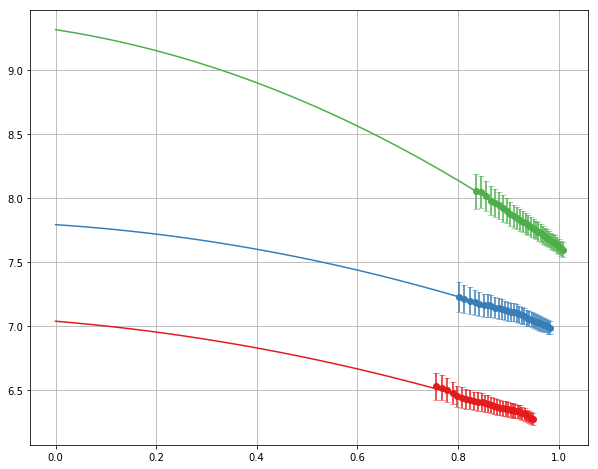

In [17]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))


alpha_poly = (1, 2)
alpha_reg = 5e-3

cm = plt.cm.get_cmap('Set1', 10)
save_data = []


for i in range(len(df)):
    gr_df = df[i].groupby(['k', 'idx']).mean().reset_index().groupby('k')

    x = gr_df['R'].mean().values
    y = gr_df['dim'].mean().values
    w = gr_df['dim'].std().values * 0.2
    save_data.append([x, y, w])
    X = np.array([x ** i for i in alpha_poly]).T

    xlin = np.linspace(0, x.max(), 100)
    Xlin = np.array([xlin ** i for i in alpha_poly]).T
    lm = Ridge(alpha=alpha_reg)
    lm.fit(X, y)
    #     x, y, color=cm(i))
    plt.errorbar(x, y, w * 0.3, fmt='o', color=cm(i), capsize=3, capthick=0.5)
    plt.plot(xlin, lm.predict(Xlin), color=cm(i))

# ax.legend()
ax.grid()
plt.show()


In [ ]:
np.save('exp.npy', save_data)

## Density test

In [18]:
def gen_sphere_data_with_distribution(n, dim, d, distrib):
    if distrib == 'uniform':
        V = np.random.randn(n,d + 1)
    elif distrib == 'nonuniform':
        V = (np.random.rand(n,d + 1) - 0.5) * 3
    data = pd.DataFrame(np.hstack([V/np.sqrt(np.sum(V**2, axis=1))[:,None],
                                          np.zeros((n, dim - d - 1))]))
    assert data.shape == (n, dim)
    return data

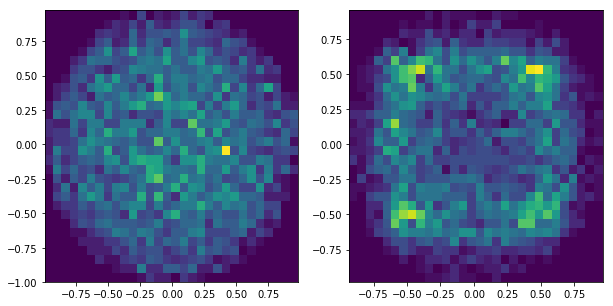

In [19]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
data = gen_sphere_data_with_distribution(5000, 5, 4, 'uniform')
plt.hist2d(data[0], data[1], bins=30)

plt.subplot(122)
data = gen_sphere_data_with_distribution(5000, 5, 4, 'nonuniform')
plt.hist2d(data[0], data[1], bins=30)

plt.show()

In [21]:
res = []
for i in range(10):
    data = gen_sphere_data_with_distribution(1000, 7, 5, 'uniform')
    res.append([mle(data)[0].mean(), geomle(data, nb_iter1=1, k1=10, k2=40)])
                
res = np.mean(res, axis=0)
print('Uniform')
print('MLE:    {:.4f}'.format(res[0]))
print('GeoMLE: {:.4f}'.format(res[1]))


res = []
for i in range(10):
    data = gen_sphere_data_with_distribution(1000, 7, 5, 'nonuniform')
    res.append([mle(data)[0].mean(), geomle(data, nb_iter1=1, k1=10, k2=40)])
                
res = np.mean(res, axis=0)
print('NonUniform')
print('MLE:    {:.4f}'.format(res[0]))
print('GeoMLE: {:.4f}'.format(res[1]))

Uniform
MLE:    4.8311
GeoMLE: 5.0961
NonUniform
MLE:    4.5838
GeoMLE: 4.9490


## Funcs

In [22]:
def run_one_test(args):
    try:
        data = DG.gen_data(args['name'], args['N'], args['D'], args['d'], args['noise'])
        res, t = DE.estimateAllMethod(data)
        res['Dataset'] = args['name']
        res['Num'] = args['N']
        res['Dim'] = args['D']
        res['RealDim'] = args['d']
        return list(res.values()), list(t.values())
    except:
        print('WRONG with {}'.format(args))


In [23]:
def run_test(func, steps, const_args, n_repetition, n_jobs):
    with parallel_backend('multiprocessing'):
        result = Parallel(n_jobs=n_jobs)(delayed(func)(add_args(const_args, step))
                                 for step in tqdm(steps * n_repetition))
    result = [i for i in result if i is not None]
    times_res = np.array(list(map(ig1, result)))
    dims_res = np.array(list(map(ig0, result)))
    cols = DE.names + ['Dataset', 'Num', 'Dim', 'RealDim']
    df = pd.DataFrame(dims_res, columns=cols)
    df = df.set_index('Dataset').astype('float').reset_index()
    return df

## Dependacne of manifold dimension

In [24]:
DE = DimEst()
DG = DataGenerator()
DG.dict_gen.keys()

steps = np.arange(2, 100, 4).tolist()
args = {'name': 'Sphere', 'D': 100,
        'N': 1000, 'noise': 0}

In [25]:
def add_args(const_args, step):
    args = {**const_args}
    args['d'] = step
    assert len({'name', 'D', 'd', 'N', 'noise'} & set(args.keys())) == 5
    return args

In [26]:
names = DE.names
n_repetition = 3

df = run_test(run_one_test, steps, args, n_repetition, 32)

100%|██████████| 75/75 [02:00<00:00,  1.61s/it]


In [27]:
df_mean = df.groupby(['Dataset', 'Num', 'Dim', 'RealDim']).mean().reset_index()

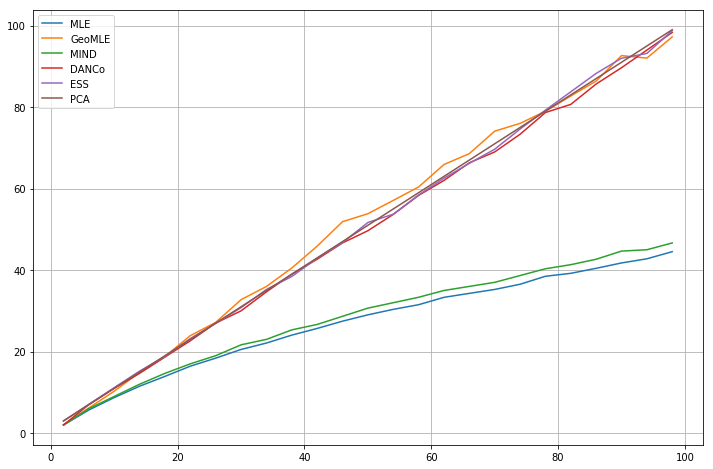

In [28]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

for name in names:
    ax.plot(df_mean['RealDim'], df_mean[name], label=name)
    
ax.legend()
ax.grid()
plt.show()

## Dependacne of Num points

In [29]:
DE = DimEst()
DG = DataGenerator()

In [30]:
DG.dict_gen.keys()

dict_keys(['Helix1d', 'Helix2d', 'Helicoid', 'Spiral', 'Roll', 'Scurve', 'Star', 'Moebius', 'Sphere', 'Norm', 'Uniform', 'Cubic', 'Affine_3to5', 'Affine', 'Nonlinear_4to6', 'Nonlinear', 'Paraboloid', 'Digits', 'Isomap', 'Hands', 'ISOLET', 'MNISTd'])

In [31]:
steps = [
    ('Sphere',  5,  3),
    ('Sphere',  10, 5),
    ('Sphere',  15, 10),
    ('Sphere',  35, 30),
    ('Sphere',  55, 50),
    ('Sphere',  75, 70),
    
    ('Affine_3to5',  5,  3),
    ('Affine',       5,  5),
    ('Affine',       10, 10),
    ('Affine',       20, 20),
    
    ('Nonlinear_4to6',  6,  4),
    ('Nonlinear',       8,  4),
    ('Nonlinear',       36, 6),
    ('Nonlinear',       64, 8),
    ('Nonlinear',       72, 12),
    
    ('Spiral',   3,  1),
    ('Spiral',   13, 1),
    ('Helix1d',  3,  1),
    ('Helix1d',  13, 1),
    ('Helix2d',  3,  2),
    ('Helix2d',  13, 2),
    ('Helicoid', 3,  2),
    ('Helicoid', 13, 2),
    ('Roll',     3,  2),
    ('Roll',     13, 2),
    ('Scurve',   3,  2),
    ('Scurve',   13, 2),
    ('Moebius',  3,  2),
    
    ('Uniform', 10, 5),
    ('Uniform', 15, 10),
    ('Uniform', 35, 30),
    ('Uniform', 55, 50),
    ('Uniform', 75, 70),
     
    ('Norm', 20, 20),
    ('Norm', 50, 20),
    ('Norm', 50, 50),
    ('Norm', 70, 50),
    
    ('Paraboloid', 12, 3),
    ('Paraboloid', 21, 6),
    ('Paraboloid', 30, 9),
    ('Paraboloid', 39, 12),
    ('Paraboloid', 48, 15),
    
    ('Cubic', 5,  3),
    ('Cubic', 35, 30),
    ('Cubic', 90, 70),
]

In [32]:
len(steps)

45

In [33]:
def add_args(const_args, step):
    args = {}
    args['N'] = const_args['N']
    args['noise'] = const_args['noise']
    args['name'] = step[0]
    args['D'] = step[1]
    args['d'] = step[2]
    return args

In [34]:
N_steps = np.concatenate((np.arange(100, 1000, 200), 
                          np.arange(1000, 2000, 250), 
                          np.arange(2000, 3501, 500)))                      

In [35]:
N_steps

array([ 100,  300,  500,  700,  900, 1000, 1250, 1500, 1750, 2000, 2500,
       3000, 3500])

In [36]:
names = DE.names
n_repetition = 5

mpe = []
for N_i in N_steps:
    args = {'N': N_i, 'noise': 0}
    df = run_test(run_one_test, steps, args, n_repetition, 30)
    dfr = df.round()
    mpe_i = abs(dfr[names].sub(dfr['RealDim'], axis=0)).mul(dfr['RealDim']**-1, axis=0).mean(axis=0).values
    mpe.append(mpe_i)

mpe = np.array(mpe)

 80%|████████  | 181/225 [00:28<00:09,  4.89it/s]

WRONG with {'N': 100, 'noise': 0, 'name': 'Nonlinear', 'D': 72, 'd': 12}


100%|██████████| 225/225 [00:37<00:00,  5.98it/s]


WRONG with {'N': 100, 'noise': 0, 'name': 'Cubic', 'D': 90, 'd': 70}


100%|██████████| 225/225 [22:43<00:00, 10.58s/it]


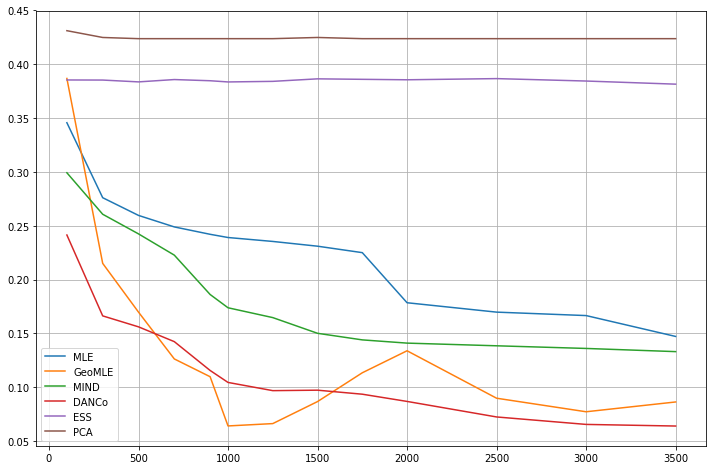

In [37]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

for mpe_i, name in zip(mpe.T, names):
    ax.plot(N_steps, mpe_i, label=name)
    
ax.legend()
ax.grid()
plt.show()

In [ ]:
result = pd.DataFrame(mpe, columns=names)
result['N'] = N_steps
result.to_csv('n_steps.csv', index=False)

## Dolan More Curve

In [38]:
DE = DimEst()
DG = DataGenerator()

In [39]:
DG.dict_gen.keys()

dict_keys(['Helix1d', 'Helix2d', 'Helicoid', 'Spiral', 'Roll', 'Scurve', 'Star', 'Moebius', 'Sphere', 'Norm', 'Uniform', 'Cubic', 'Affine_3to5', 'Affine', 'Nonlinear_4to6', 'Nonlinear', 'Paraboloid', 'Digits', 'Isomap', 'Hands', 'ISOLET', 'MNISTd'])

In [40]:
steps = [
    ('Sphere',  5,  3),
    ('Sphere',  10, 5),
    ('Sphere',  15, 10),
    ('Sphere',  35, 30),
    ('Sphere',  55, 50),
    ('Sphere',  75, 70),
    
    ('Affine_3to5',  5,  3),
    ('Affine',       5,  5),
    ('Affine',       10, 10),
    ('Affine',       20, 20),
    
    ('Nonlinear_4to6',  6,  4),
    ('Nonlinear',       8,  4),
    ('Nonlinear',       36, 6),
    ('Nonlinear',       64, 8),
    ('Nonlinear',       72, 12),
    
    ('Spiral',   3,  1),
    ('Spiral',   13, 1),
    ('Helix1d',  3,  1),
    ('Helix1d',  13, 1),
    ('Helix2d',  3,  2),
    ('Helix2d',  13, 2),
    ('Helicoid', 3,  2),
    ('Helicoid', 13, 2),
    ('Roll',     3,  2),
    ('Roll',     13, 2),
    ('Scurve',   3,  2),
    ('Scurve',   13, 2),
    ('Moebius',  3,  2),
    
    ('Uniform', 10, 5),
    ('Uniform', 15, 10),
    ('Uniform', 35, 30),
    ('Uniform', 55, 50),
    ('Uniform', 75, 70),
     
    ('Norm', 20, 20),
    ('Norm', 50, 20),
    ('Norm', 50, 50),
    ('Norm', 70, 50),
    
    ('Paraboloid', 12, 3),
    ('Paraboloid', 21, 6),
    ('Paraboloid', 30, 9),
    ('Paraboloid', 39, 12),
    ('Paraboloid', 48, 15),
    
    ('Cubic', 5,  3),
    ('Cubic', 35, 30),
    ('Cubic', 90, 70),
]

In [41]:
def add_args(const_args, step):
    args = {**const_args}
    args['name'] = step[0]
    args['D'] = step[1]
    args['d'] = step[2]
    assert len({'name', 'D', 'd', 'N', 'noise'} & set(args.keys())) == 5
    return args

In [42]:
n_repetition = 5
args = {'N': 1000, 'noise': 0}
df = run_test(run_one_test, steps, args, n_repetition, 30)

100%|██████████| 225/225 [05:10<00:00,  2.29s/it]


In [43]:
df.groupby(['Dataset', 'Num', 'Dim', 'RealDim']).mean()

MLE     GeoMLE  MIND  DANCo  \
Dataset        Num    Dim  RealDim                                      
Affine         1000.0 5.0  5.0       4.471013   5.000000   4.8    5.0   
                      10.0 10.0      8.020074   9.967841   8.0   10.0   
                      20.0 20.0     14.216112  18.807588  15.0   19.6   
Affine_3to5    1000.0 5.0  3.0       2.841891   3.154921   3.0    3.0   
Cubic          1000.0 5.0  3.0       3.070595   3.029847   3.0    3.2   
                      35.0 30.0     19.567014  29.789387  20.0   30.2   
                      90.0 70.0     34.292747  74.075070  35.8   72.8   
Helicoid       1000.0 3.0  2.0       2.080444   2.129945   2.0    2.0   
                      13.0 2.0       2.077040   2.125410   2.0    2.0   
Helix1d        1000.0 3.0  1.0       1.005704   1.360117   1.0    1.0   
                      13.0 1.0       1.004215   1.433301   1.0    1.0   
Helix2d        1000.0 3.0  2.0       2.748042   2.354156   2.6    3.0   
                      13.0 2.0       2.716542   2.512811   2.6    3.0   
Moebius        1000.0 3.0  2.0       1.988141   1.696466   2.0    2.0   
Nonlinear      1000.0 8.0  4.0       4.095118   3.370937   4.0    5.8   
                      36.0 6.0       6.723176   6.553553   6.0    8.2   
                      64.0 8.0       9.140094  10.298975   9.0   10.0   
                      72.0 12.0     13.499417  17.578370  13.6   18.0   
Nonlinear_4to6 1000.0 6.0  4.0       3.826850   4.072099   4.0    5.2   
Norm           1000.0 20.0 20.0     15.067934  20.000000  16.0   20.0   
                      50.0 20.0     15.008998  22.092710  15.8   20.4   
                           50.0     26.938298  50.000000  28.4   47.4   
                      70.0 50.0     27.068310  53.040153  28.8   48.8   
Paraboloid     1000.0 12.0 3.0       2.831125   2.969896   3.0    3.0   
                      21.0 6.0       4.743536   5.815805   5.0    6.8   
                      30.0 9.0       5.902700   8.749548   6.0    8.0   
                      39.0 12.0      6.630340  11.796125   7.0    8.0   
                      48.0 15.0      7.019859  14.129548   7.6    9.0   
Roll           1000.0 3.0  2.0       1.942500   2.432492   2.0    2.0   
                      13.0 2.0       1.950628   2.593864   2.0    2.0   
Scurve         1000.0 3.0  2.0       1.951512   2.017161   2.0    2.0   
                      13.0 2.0       1.955164   2.028894   2.0    2.0   
Sphere         1000.0 5.0  3.0       2.960153   2.981396   3.0    3.0   
                      10.0 5.0       4.843860   4.937857   5.0    6.0   
                      15.0 10.0      8.813374  10.111159   9.0   11.4   
                      35.0 30.0     20.515328  31.523914  21.6   30.6   
                      55.0 50.0     28.610716  50.858115  30.4   50.4   
                      75.0 70.0     35.549612  70.181915  37.4   69.4   
Spiral         1000.0 3.0  1.0       1.788685   1.523860   1.0    1.0   
                      13.0 1.0       1.780426   1.430573   1.0    1.0   
Uniform        1000.0 10.0 5.0       4.477618   4.651074   4.8    5.0   
                      15.0 10.0      8.002896   8.947939   8.0    9.4   
                      35.0 30.0     19.187726  29.492222  19.8   30.6   
                      55.0 50.0     27.056050  49.712814  28.6   51.8   
                      75.0 70.0     33.806117  72.446160  35.6   72.4   

                                          ESS   PCA  
Dataset        Num    Dim  RealDim                   
Affine         1000.0 5.0  5.0       4.921080   5.0  
                      10.0 10.0      9.965035  10.0  
                      20.0 20.0     20.047375  20.0  
Affine_3to5    1000.0 5.0  3.0       2.561339   3.0  
Cubic          1000.0 5.0  3.0       4.047324   4.0  
                      35.0 30.0     30.735383  31.0  
                      90.0 70.0     70.225841  71.0  
Helicoid       1000.0 3.0  2.0       1.838152   2.0  
                      13.0 2.0       1.841390   2.0  
Helix1d        1

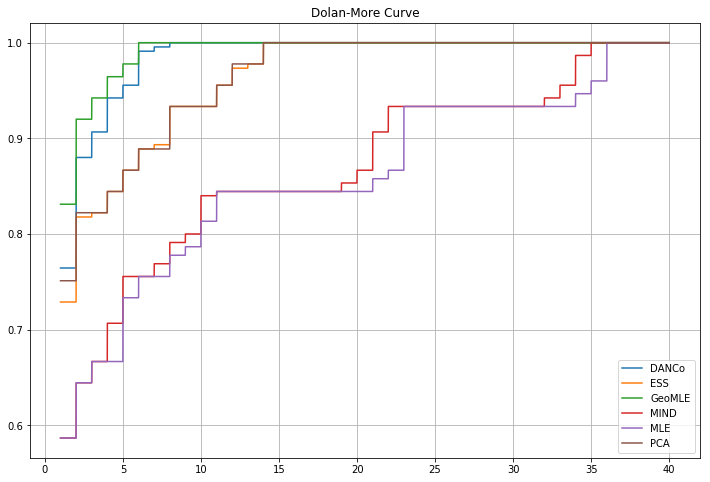

In [44]:
dfr = df.copy().round()
names = dfr.columns.difference(['Dataset', 'Num', 'Dim', 'RealDim'])

f, ax = plt.subplots(1, 1, figsize=(12, 8))
nsteps = 5001
max_tau = 40
errors_total = abs(dfr[names].sub(dfr['RealDim'], axis=0).values)
errors_total = np.max([errors_total, np.ones_like(errors_total)], axis=0)


taus = np.linspace(1, max_tau, nsteps)        
rhos = np.zeros((nsteps, len(names)))
for cnt, tau in enumerate(taus):
    rhos[cnt] = np.sum(errors_total <= tau, axis=0)

for i in range(len(names)):
    ax.plot(taus, rhos[:,i]/errors_total.shape[0], label=names[i])

ax.set_title('Dolan-More Curve')
ax.legend()
ax.grid()



## Dependece on noise

In [45]:
DE = DimEst()
DG = DataGenerator()

In [46]:
DG.dict_gen.keys()

dict_keys(['Helix1d', 'Helix2d', 'Helicoid', 'Spiral', 'Roll', 'Scurve', 'Star', 'Moebius', 'Sphere', 'Norm', 'Uniform', 'Cubic', 'Affine_3to5', 'Affine', 'Nonlinear_4to6', 'Nonlinear', 'Paraboloid', 'Digits', 'Isomap', 'Hands', 'ISOLET', 'MNISTd'])

In [47]:
steps = [
    ('Sphere',  5,  3),
    ('Sphere',  10, 5),
    ('Sphere',  15, 10),
    ('Sphere',  35, 30),
    ('Sphere',  55, 50),
    ('Sphere',  75, 70),
    
    ('Affine_3to5',  5,  3),
    ('Affine',       5,  5),
    ('Affine',       10, 10),
    ('Affine',       20, 20),
    
    ('Nonlinear_4to6',  6,  4),
    ('Nonlinear',       8,  4),
    ('Nonlinear',       36, 6),
    ('Nonlinear',       64, 8),
    ('Nonlinear',       72, 12),
    
    ('Spiral',   3,  1),
    ('Spiral',   13, 1),
    ('Helix1d',  3,  1),
    ('Helix1d',  13, 1),
    ('Helix2d',  3,  2),
    ('Helix2d',  13, 2),
    ('Helicoid', 3,  2),
    ('Helicoid', 13, 2),
    ('Roll',     3,  2),
    ('Roll',     13, 2),
    ('Scurve',   3,  2),
    ('Scurve',   13, 2),
    ('Moebius',  3,  2),
    
    ('Uniform', 10, 5),
    ('Uniform', 15, 10),
    ('Uniform', 35, 30),
    ('Uniform', 55, 50),
    ('Uniform', 75, 70),
     
    ('Norm', 20, 20),
    ('Norm', 50, 20),
    ('Norm', 50, 50),
    ('Norm', 70, 50),
    
    ('Paraboloid', 12, 3),
    ('Paraboloid', 21, 6),
    ('Paraboloid', 30, 9),
    ('Paraboloid', 39, 12),
    ('Paraboloid', 48, 15),
    
    ('Cubic', 5,  3),
    ('Cubic', 35, 30),
    ('Cubic', 90, 70),
]

In [48]:
len(steps)

45

In [49]:
def add_args(const_args, step):
    args = {}
    args['N'] = const_args['N']
    args['noise'] = const_args['noise']
    args['name'] = step[0]
    args['D'] = step[1]
    args['d'] = step[2]
    return args

In [50]:
noise_steps = [0, 0.01, 0.02, 0.03, 0.04, 0.05]                     

In [51]:
names = DE.names
n_repetition = 5

mpe = []
for noise in noise_steps:
    args = {'N': 1000, 'noise': noise}
    df = run_test(run_one_test, steps, args, n_repetition, 30)
    dfr = df.round()
    mpe_i = abs(dfr[names].sub(dfr['RealDim'], axis=0)).mul(dfr['RealDim']**-1, axis=0).mean(axis=0).values
    mpe.append(mpe_i)

mpe = np.array(mpe)

100%|██████████| 225/225 [05:05<00:00,  1.75s/it]


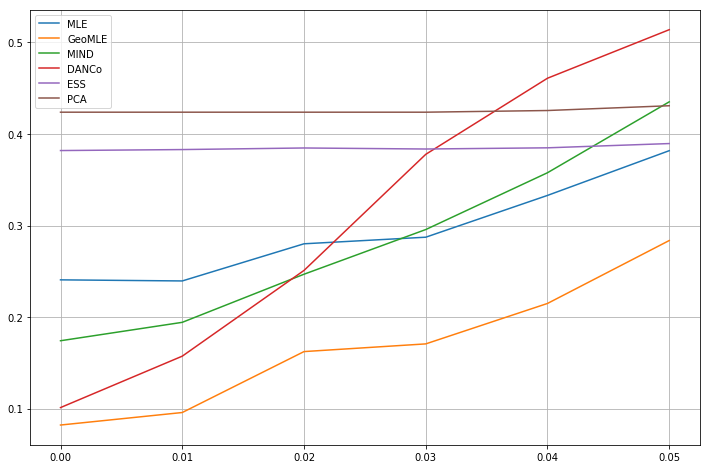

In [52]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

for mpe_i, name in zip(mpe.T, names):
    ax.plot(noise_steps, mpe_i, label=name)
    
ax.legend()
ax.grid()
plt.show()

In [56]:
result = pd.DataFrame(mpe, columns=names)
result['noise'] = noise_steps
result.to_csv('noise.csv', index=False)